In [150]:
import numpy as np
import scipy
#from mpmath import *
from mpmath import hyp1f1, gamma
import matplotlib.pyplot as plt

G = 6.67430*1e-11 
c = 299792458. 
M_sun = 1.989*1e30

In [151]:
class point_lens:
    '''
    A class containing functions for studying an isolated point lens case. 
    In such cases, two images are formed: one minima (type I) and one saddle (type II). 
    '''
    
    # image positions
    def xm(self, y):
        return (y+np.sqrt(y**2+4))/2
    def xs(self, y):
        return (y-np.sqrt(y**2+4))/2
    
    #image magnifications
    def um(self, y):
        return 1/2 + (y**2+2)/(2*y*np.sqrt(y**2+4))   
    def us(self, y):
        return 1/2 - (y**2+2)/(2*y*np.sqrt(y**2+4))

    #time delay between the two images
    def td_pnt_dimensionless(self, y):
        return (y*np.sqrt(y**2+4))/2. + np.log((np.sqrt(y**2+4)+y)/(np.sqrt(y**2+4)-y))

    def td_pnt_sec(self, mlz, y):
        return (4*G*M_sun*mlz/c**3)*((y*np.sqrt(y**2+4))/2. + np.log((np.sqrt(y**2+4)+y)/(np.sqrt(y**2+4)-y)))

    # Geometric and Quasi Geometric approximations
    def Fw_geo(self, w, y):
        return np.sqrt(np.abs(self.um(y))) - 1j*np.sqrt(np.abs(self.us(y)))*np.exp(1j*w*self.td_pnt_dimensionless(y))
    
    def Fw_qgeo(self, w, y):
        return self.Fw_geo(w,y) + (1j/(3*w))*((4*self.xm(y)**2-1)/(pow((self.xm(y)**2+1),3)*(self.xm(y)**2-1)))*np.sqrt(np.abs(self.um(y))) + \
               (1/(3*w))*((4*self.xs(y)**2-1)/(pow((self.xs(y)**2+1),3)*(self.xs(y)**2-1)))*np.sqrt(np.abs(self.us(y)))*np.exp(1j*w*self.td_pnt_dimensionless(y)) 
    
    # dimensionless frequency, w(f)
    def wf(self, f, ml, zl=0):
        return f*8.*np.pi*G*ml*(1+zl)*M_sun/c**3.

    def wc_geo_re0p1(self, y):
    # returns wc(y) (cutoff w for a given y) such that w > wc gives relative error < 0.1 % when 
    # geometric optics is used. Valid for y in range (0.01, 5.00)
        if y <= 0.12:
            wc = 15112.5 - 52563.5*y
        elif 0.12 < y <= 1.5:
            wc = -34.08 - 12.84*pow(y,-1) + 114.33*pow(y,-2) + 0.89*pow(y,-3) 
        elif y > 1.5:
            wc = -15.02 + 18.25*y - 2.66*y**2
        if (y < 0.01 or round(y,3) > 5.00):
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        return wc

    def wc_Qgeo_re0p1(self, y):
    # same for Quasi Geometric approximation    
        wc = 9*pow(y,-1) + 0.04*pow(y,-2)

        if (y < 0.01 or round(y,3) > 5.00):
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        return wc  

    # same for 1% relative error
    def wc_geo_re1p0(self, y):
        if y <= 0.071:
            wc = 16604 - 202686*y
        elif y > 0.071:
            wc = 0.64 + 0.97*pow(y, -1) + 6*pow(y, -2) + 0.38*pow(y, -3)  
        if (y < 0.01 or round(y,3) > 5.00):
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        return wc

    def wc_Qgeo_re1p0(self, y):
        wc = 4*pow(y,-1) - np.log(y)/5 
        if (y < 0.01 or round(y,3) > 5.00):
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        return wc  
        
    # Amplification Factor, F(w, y), for point lens using actual analytic formula. 
    # It breaks down, or is difficult to compute, when the system approaches geometrical optics regime.
    def pnt_Fw(self, w, y):
        if w==0:
            return 1
        else:
            w = np.float128(w)
            xm = np.float128((y+np.sqrt(y*y + 4.))/2.)
            pm = np.float128(pow(xm-y,2)/2 - np.log(xm))
            hp = np.log(w/2.)-(2.*pm)
            h = np.exp((np.pi*w/4.)+1j*(hp*w/2.))
            gm = gamma(1.-(1j*w/2.))
            hf = hyp1f1((1j*w/2.),1.,(1j*y*y*w/2.))
            Ff= h*gm*hf
            return complex(Ff.real, Ff.imag)  

    # An efficient computation that uses our knowledge from the geometric optics limit. 
    # It can handle any values.
    def pnt_Fw_eff(self, w, y):
        wc_geo = self.wc_geo_re0p1(y)
        wc_Qgeo = self.wc_Qgeo_re0p1(y)
        if w < wc_Qgeo:
            return self.pnt_Fw(w,y)
        elif (w>=wc_Qgeo and w<wc_geo):
            return self.Fw_qgeo(w,y)
        else:
            return self.Fw_geo(w,y)
    
    # mapping fucntion for the above function: this can take an array as input
    def pnt_Fw_eff_map(self, ws, y):
        return np.array(list(map(lambda w: self.pnt_Fw_eff(w, y), ws)))
    
    def pnt_Fw_map(self, ws, y):
        return np.array(list(map(lambda w: self.pnt_Fw(w, y), ws)))
    
    def pnt_Ff_map(self, fs, ml, y, zl=0):
        return np.array(list(map(lambda f: self.pnt_Ff(f, ml, y, zl), fs)))
    
    # Following functions compute the same with dimension-full frequency as inputs.
    def pnt_Ff(self, f, m, y, zl=0):
        w = self.wf(f, m, zl)
        return self.pnt_Fw(w, y)
    
    def Ff_geo(self, f, m, y, zl=0):
        w = self.wf(f, m, zl)
        return self.Fw_geo(w, y)
    
    def Ff_qgeo(self, f, m, y, zl=0):
        w = self.wf(f, m, zl)
        return self.Fw_geo(w, y)

In [152]:
pnt_lens = point_lens()

## Example 1: Generating Amplification Factor F(f) for different lens parameters: {Mlz, y} 
### where Mlz $\equiv$  redshifted point lens mass and y $\equiv $  impact parameter.
### Mlz $\in$ {1e1, 1e4}, and y $\in$ {0.1, 3}.

### While computing F(f) we will use "pnt_Fw_eff_map" function of the package which is a function of {w, y} 
### where w $\equiv$ dimensionless frequency as defined in the "wf" function above. "Mlz" gets absorbed into "wf", thus no longer an independent variable.
### Therefore, our final function, i.e., "pnt_Fw_eff", is only function of {w, y}.

### Ex 1: {mlz, y} = {1e2, 0.1}

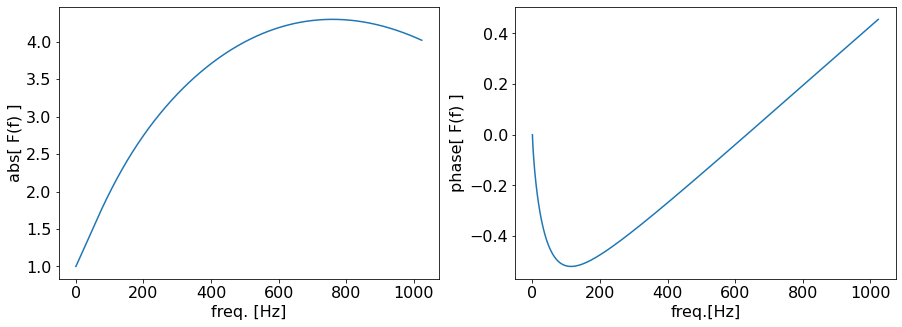

In [153]:
fs = np.arange(0, 1024, 0.25)  # frequency in Hz that we are interested in 

# lens parameters
mlz, yl = 1e2, 0.1  
wfs = pnt_lens.wf(fs, ml=mlz)   # converting fs to dimensionless freq. using microlens mass

# computing F(f)
Ff = pnt_lens.pnt_Fw_eff_map(wfs, y=yl)  

# plotting F(f)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(fs, np.abs(Ff))
ax[1].plot(fs, np.angle(Ff))

fsz=16
ax[0].set_xlabel('freq. [Hz]', fontsize=fsz)
ax[0].set_ylabel('abs[ F(f) ]', fontsize=fsz)
ax[1].set_xlabel('freq.[Hz]', fontsize=fsz)
ax[1].set_ylabel('phase[ F(f) ]', fontsize=fsz)

ax[0].tick_params(axis='both', which='major', labelsize=fsz)   
ax[1].tick_params(axis='both', which='major', labelsize=fsz)

plt.show()

### Ex 2: {mlz, y} = {1e3, 1.0}

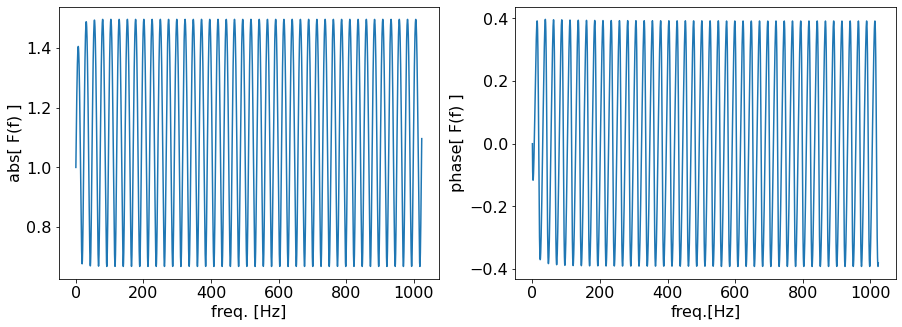

In [154]:
fs = np.arange(0, 1024, 0.25)  # frequency in Hz that we are interested in 

# lens parameters
mlz, yl = 1e3, 1.0  
wfs = pnt_lens.wf(fs, ml=mlz)   # converting fs to dimensionless freq. using microlens mass

# computing F(f)
Ff = pnt_lens.pnt_Fw_eff_map(wfs, y=yl)  

# plotting F(f)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(fs, np.abs(Ff))
ax[1].plot(fs, np.angle(Ff))

fsz=16
ax[0].set_xlabel('freq. [Hz]', fontsize=fsz)
ax[0].set_ylabel('abs[ F(f) ]', fontsize=fsz)
ax[1].set_xlabel('freq.[Hz]', fontsize=fsz)
ax[1].set_ylabel('phase[ F(f) ]', fontsize=fsz)

ax[0].tick_params(axis='both', which='major', labelsize=fsz)   
ax[1].tick_params(axis='both', which='major', labelsize=fsz)

plt.show()

## Grid Generation

### To generate grid for the following grid points in {w, y}, we can use the code provided after the following cell:

In [155]:
# Grid in y
yss = [np.arange(1e-2, 1e-1, 1e-5), np.arange(1e-1, 1e-0, 1e-4), np.arange(1e0, 2e0, 1e-3),\
      np.arange(2e0, 5e0+1e-2, 1e-2)]
ys = np.concatenate(yss)
len_ys = len(ys)

# Grid in w
wss = [np.arange(1e-4, 1e-3, 1e-6),
np.arange(1e-3, 1e-2, 1e-5),
np.arange(1e-2, 1e-1, 1e-4),
np.arange(1e-1, 1e-0, 1e-3),
np.arange(1e-0, 1e1, 1e-2),
np.arange(1e1, 1e2, 1e-1),
np.arange(1e2, 1e3, 5e-1),
np.arange(1e3, 1e4+1e0, 1e0)]
ws = np.concatenate(wss)
len_iws = [len(wss[i]) for i in range(len(wss))]

len_ws = np.sum(len_iws)

# Total points in the grid
print('Details of the grid for the function F(w, y): ')
print('w: {{{:.4f}, {:.0f}}}'.format(min(ws), max(ws)))
print('y: {{{:.2f}, {:.0f}}}'.format(min(ys), max(ys)))
print('Total points in the grid {} x {} = {}'.format(len_ws, len_ys, len_ws*len_ys))

Details of the grid for the function F(w, y): 
w: {0.0001, 10000}
y: {0.01, 5}
Total points in the grid 16202 x 19301 = 312714802


#### Run the following program to create F(w, y) grid for the above grid points. It will be saved as a fits file "pnt_Ff_grid_geo_rerr_1p0.fits" of approx ~ 5 GB.
#### This code uses mp.Pool so provide the number of processors while creating pool object. Currently it has been set to "pool = mp.Pool(processes=10)".
#### It will run for O(10) minutes depending upon the number of cores you provide.  

In [110]:
# import numpy as np
# import time
# import sys

# from mpmath import hyp1f1, gamma
# import math
# import matplotlib.pyplot as plt

# from mpmath import hyp1f1, gamma
# import scipy
# import math

# from astropy.io import fits
# import multiprocessing as mp
# from functools import partial


# G = 6.67430*1e-11 
# c = 299792458. 
# Ms = 1.989*1e30

# ### Function Definitions ###
# def xm(y):
#     return (y+np.sqrt(y**2+4))/2
# def xs(y):
#     return (y-np.sqrt(y**2+4))/2
    
# def um(y):
#     return 1/2 + (y**2+2)/(2*y*np.sqrt(y**2+4))   
# def us(y):
#     return 1/2 - (y**2+2)/(2*y*np.sqrt(y**2+4))
    
# def dT(y):
#     return (y*np.sqrt(y**2+4))/2. + np.log((np.sqrt(y**2+4)+y)/(np.sqrt(y**2+4)-y))

# def Ff_geo(w,y):
#     return np.sqrt(np.abs(um(y))) - 1j*np.sqrt(np.abs(us(y)))*np.exp(1j*w*dT(y))

# def Ff_qgeo(w,y):
#     return Ff_geo(w,y) + (1j/(3*w))*((4*xm(y)**2-1)/(pow((xm(y)**2+1),3)*(xm(y)**2-1)))*np.sqrt(np.abs(um(y))) + \
#            (1/(3*w))*((4*xs(y)**2-1)/(pow((xs(y)**2+1),3)*(xs(y)**2-1)))*np.sqrt(np.abs(us(y)))*np.exp(1j*w*dT(y)) 

# def wf(f,ml):
#     return f*8.*np.pi*G*ml*Ms/c**3.

# # returns wc(y) (cutoff w for a given y) such that w > wc gives relative error <0.1 % when geometric optics is used 
# def wc_geo_re0p1(y):
#     # valid for y in range (0.01, 5.00)
#     if y <= 0.12:
#         wc = 15112.5 - 52563.5*y
#     elif 0.12 < y <= 1.5:
#         wc = -34.08 - 12.84*pow(y,-1) + 114.33*pow(y,-2) + 0.89*pow(y,-3) 
#     elif 1.5 < y:
#         wc = -15.02 + 18.25*y - 2.66*y**2
        
#     if (y < 0.01 or round(y,3) > 5.00):
#         print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
#     return wc

# def wc_Qgeo_re0p1(y):
#     # valid for y in range (0.01, 5.00)
#     wc = 9*pow(y,-1) + 0.04*pow(y,-2)
    
#     if (y < 0.01 or round(y,3) > 5.00):
#         print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
   
#     return wc  


# def map_wc_geo_re0p1(ys):
#     return np.array(list(map(lambda y: wc_geo_re0p1(y), ys)))


# def map_wc_Qgeo_re0p1(ys):
#     return np.array(list(map(lambda y: wc_Qgeo_re0p1(y), ys)))


# def map_wc_Qgeo_re0p1(ys):
#     return np.array(list(map(lambda y: wc_Qgeo_re0p1(y), ys)))


# def wc_geo_re1p0(y):
#     # valid for y in range (0.01, 5.00)
#     if y <= 0.071:
#         wc = 16604 - 202686*y
#     elif y > 0.071:
#         wc = 0.64 + 0.97*pow(y, -1) + 6*pow(y, -2) + 0.38*pow(y, -3)  
#     if (y < 0.01 or round(y,3) > 5.00):
#         print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
#     return wc

# def wc_Qgeo_re1p0(y):
#     # valid for y in range (0.01, 5.00)
#     wc = 4*pow(y,-1) - np.log(y)/5 
#     if (y < 0.01 or round(y,3) > 5.00):
#         print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
#     return wc  

# def map_wc_geo_re1p0(ys):
#     return np.array(list(map(lambda y: wc_geo_re1p0(y), ys)))

# def map_wc_Qgeo_re1p0(ys):
#     return np.array(list(map(lambda y: wc_Qgeo_re1p0(y), ys)))

# def pnt_Fw(w, y):
#     if w==0:
#         return 1
#     else:
#         w=np.float128(w)
#         xm = (y+np.sqrt(y*y + 4.))/2.
#         pm = pow(xm-y,2)/2 - np.log(xm)
#         hp = np.log(w/2.)-(2.*pm)
#         h = np.exp((np.pi*w/4.)+1j*(hp*w/2.))
#         gm = gamma(1.-(1j*w/2.))
#         hf = hyp1f1((1j*w/2.),1.,(1j*y*y*w/2.))
#         Ff= h*gm*hf
#         return complex(Ff.real, Ff.imag)  

# def Ff_eff(w, y):
#     wc=wc0p1(y)
#     if w<wc:
#         return pnt_Ff(w,y)
#     else:
#         return Ffqgeo(w,y)

# def Fw_pnt_eff(w, y):
#     wc_geo = wc_geo_re0p1(y)
#     wc_Qgeo = wc_Qgeo_re0p1(y)
#     if w < wc_Qgeo:
#         return pnt_Fw(w,y)
#     elif (w>=wc_Qgeo and w<wc_geo):
#         return Ff_qgeo(w,y)
#     else:
#         return Ff_geo(w,y)
    
# # Grid Generation
# yss = [np.arange(1e-2, 1e-1, 1e-5), np.arange(1e-1, 1e-0, 1e-4), np.arange(1e0, 2e0, 1e-3),\
#       np.arange(2e0, 5e0+1e-2, 1e-2)]
# ys = np.concatenate(yss)
# lenyss = [len(yss[i]) for i in range(len(yss))]
# yls = [1e-2, 1e-1, 1e-0, 2e0]
# dys = [1e-5, 1e-4, 1e-3, 1e-2]

# wss = [np.arange(1e-4, 1e-3, 1e-6),
# np.arange(1e-3, 1e-2, 1e-5),
# np.arange(1e-2, 1e-1, 1e-4),
# np.arange(1e-1, 1e-0, 1e-3),
# np.arange(1e-0, 1e1, 1e-2),
# np.arange(1e1, 1e2, 1e-1),
# np.arange(1e2, 1e3, 5e-1),
# np.arange(1e3, 1e4+1e0, 1e0)]
# ws = np.concatenate(wss)
# lenwss = [len(wss[i]) for i in range(len(wss))]
# wls = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
# dws = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1e0]

# y_w_grid = []
# for y in ys:
#     wc = wc_geo_re1p0(y)
#     tmp_ws = ws[ws <= 1.1*wc]
#     y_w_grid.append([y, tmp_ws])
    
# y_w_grid = np.array(y_w_grid, dtype=object)      

# print('ys: ({:.3f}, {:.3f}), len(ys)={}'.format(ys[0], ys[-1], len(ys)))
# print('ws: ({:.4f}, {:2f}), max_len(ws)={}'.format(ws[0], ws[-1], len(ws)))
# print('\nGrid Size = {}'.format(len(np.concatenate(y_w_grid[:,1]))))

# pool = mp.Pool(processes=10)
      
# t1=time.time()
# Ff_grid=[]
# for y_ws in y_w_grid:
#     g_y = y_ws[0]
#     g_ws = y_ws[1]
#     Ff_eff_partial = partial(Fw_pnt_eff, y = g_y)
#     tmp_res = np.array(list(pool.map(Ff_eff_partial, g_ws)))
# #     tmp = np.array(list(map(lambda w: Ff_eff(w, y), ws)))
#     yls = [g_y]*len(g_ws)
#     Ff_grid.append(np.dstack((g_ws, yls, np.real(tmp_res), np.imag(tmp_res)))[0])

# t2 = time.time() 
# print('\nComputation Time (generation) = {:.2f} s'.format(t2-t1))



# t1 = time.time()
# from astropy.io import fits
# Ff_grid_c = np.concatenate(Ff_grid, dtype=np.float64) 
# hdu = fits.PrimaryHDU()
# hdu.data = Ff_grid_c
# hdu.writeto('pnt_Ff_grid_geo_rerr_1p0.fits', overwrite=True)
# t2 = time.time() 
# print('Computation Time (exporting) = {:.2f} s'.format(t2-t1))    

#### To Read the fits file, use the following lines:

In [ ]:
# # Grid Parameters
# yss = [np.arange(1e-2, 1e-1, 1e-5), np.arange(1e-1, 1e-0, 1e-4), np.arange(1e0, 2e0, 1e-3),\
#       np.arange(2e0, 5e0+1e-2, 1e-2)]
# ys = np.concatenate(yss)
# a_lenys = np.array([len(yss[i]) for i in range(len(yss))])
# a_yls = np.array([1e-2, 1e-1, 1e-0, 2e0])
# a_dys = np.array([1e-5, 1e-4, 1e-3, 1e-2])

# wss = [np.arange(1e-4, 1e-3, 1e-6),
# np.arange(1e-3, 1e-2, 1e-5),
# np.arange(1e-2, 1e-1, 1e-4),
# np.arange(1e-1, 1e-0, 1e-3),
# np.arange(1e-0, 1e1, 1e-2),
# np.arange(1e1, 1e2, 1e-1),
# np.arange(1e2, 1e3, 5e-1),
# np.arange(1e3, 1e4+1e0, 1e0)]
# ws = np.concatenate(wss)
# a_lenws = [len(wss[i]) for i in range(len(wss))]
# a_wls = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
# a_dws = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1e0]
# # Loading Result
# from astropy.io import fits  
# tmp = fits.open('grid_gen_new/pnt_Ff_grid_geo_rerr_1p0.fits')   
# data_c = tmp[0].data

# data = []
# lws=[]
# for y in ys:
#     wc = wc_geo_re1p0(y)
#     aws = ws[ws <= 1.1*wc]
#     tmp_len = len(aws)
#     lws.append(tmp_len)
#     i0=int(np.sum(lws[:-1]))
#     data.append(data_c[i0:i0+tmp_len])